# Tutorial 5 - FOSWEC
The goal of this tutorial is to show a design problem for a bottom-hinged oscillating-surge WEC.
The WEC in this tutorial is a single, fixed-bottom flap of the floating oscillating-surge WEC (FOSWEC).

* SAND report: https://doi.org/10.2172/1717884
* Journal paper: https://doi.org/10.1016/j.energy.2021.122485
* YouTube video: https://youtu.be/OUxbaEC2K6Y

This tutorial introduces...

In [22]:
import autograd.numpy as np
import capytaine as cpy
from capytaine.io.meshio import load_from_meshio
import matplotlib.pyplot as plt
from scipy.optimize import brute
import pygmsh
import gmsh
import xarray as xr
import ipympl
from scipy.optimize import curve_fit

import wecopttool as wot

## set colorblind-friendly colormap for plots
plt.style.use('tableau-colorblind10')

%matplotlib inline

Text(0, 0.5, 'Torque (Nm)')

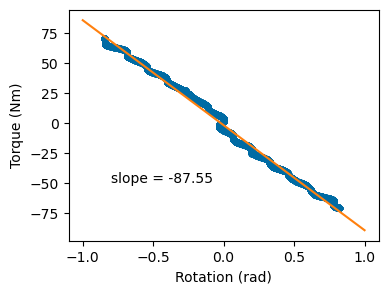

In [23]:
# load in data from ramps experiments
datafile = 'data/FOSWEC_ramps.nc'
ramps_data = xr.load_dataset(datafile)

# fit a linear curve
coefficients = np.polyfit(ramps_data['position'], ramps_data['torque'], 1)
pos_fitted = np.linspace(-1,1,100)
torque_fitted = np.polyval(coefficients, pos_fitted)

plt.figure(figsize=(4,3))
plt.plot(ramps_data['position'], ramps_data['torque'],'.')
plt.plot(pos_fitted,torque_fitted,'-')
plt.text(-0.8, -50, f'slope = {round(coefficients[0],2)}')
plt.xlabel('Rotation (rad)')
plt.ylabel('Torque (Nm)')

#plt.show()

## Single Flap Design Study
Because the hydrodynamics are so similar between both flaps of the FOSWEC (as evidenced by impedance plots above), we can simplify the design study to consider just one flap.
Results from the study should be applicable to both flaps. 


### Wave Conditions
Here, we define the wave conditions to select a proper frequency vector.
Because this study is only for regular waves, the fundamental frequency can be equal to the wave frequency and we only need about 12 frequencies total to capture all nonlinearities.

In [24]:
period = 8 # s
wavefreq = 1/period # Hz
amplitude = 0.2 # m
phase = 0 # degrees
wavedir = 0 # degrees

f1 = wavefreq
nfreq = 12

waves = wot.waves.regular_wave(f1, nfreq, wavefreq, amplitude, phase, wavedir)
freq = wot.frequency(f1, nfreq, False) # False -> no zero frequency

### Design Loop
The design loop here includes the tuned variables from above (draft and friction) as well as the center of gravity vertical location and rated generator power.
This enables a study which considers the impacts of changing the center of gravity of the flap (without altering the total mass) and using generators with different power ratings.

In [25]:
def one_flap_FOSWEC(draft, hs_coeff, z_cg_from_bottom, rotAngle):

    # parameters from experiments
    flap_height = 0.58 
    flap_draft = draft
    flap_freeboard = flap_height - flap_draft
    flap_width = 0.76
    flap_thickness_bottom = 0.05
    flap_thickness_top = 0.12
    hinge_location = -flap_draft - .046
    mass = 23.1
    pitch_inertia_about_cg = 1.19
    z_cg_from_bottom = z_cg_from_bottom
    z_cg = -flap_draft + z_cg_from_bottom

    mesh_size_factor = 0.2 # appropriate mesh size to avoid frequency spikes

    # mesh 1st flap
    with pygmsh.geo.Geometry() as geom:
        gmsh.option.setNumber('Mesh.MeshSizeFactor', mesh_size_factor)
        flap_poly = geom.add_polygon(
                [[-flap_thickness_bottom/2, -flap_width/2, -flap_draft],
                [flap_thickness_bottom/2, -flap_width/2, -flap_draft],
                [flap_thickness_top/2, -flap_width/2, flap_freeboard],
                [-flap_thickness_top/2, -flap_width/2, flap_freeboard]],mesh_size=mesh_size_factor)
        geom.rotate(flap_poly, [0,0,hinge_location], rotAngle, [0,1,0])
        geom.extrude(flap_poly,[0,flap_width,0])
        flap_mesh = geom.generate_mesh()

    # add degrees of freedom for rotation around bottom hinge
    flap_fb = cpy.FloatingBody(flap_mesh, name='flap_bow', center_of_mass=(0, 0, z_cg))
    axis = cpy.Axis(vector=(0, 1, 0), point=(0, 0, hinge_location))
    flap_fb.add_rotation_dof(name="pitch_about_hinge", axis=axis) # used for BEM
    flap_fb.rotation_center = (0, 0, hinge_location) # rotation center hydrostatics if not defined manually
    flap_fb.keep_immersed_part()

    # use parallel axis theorem to move inertia to base
    pitch_inertia_about_base = pitch_inertia_about_cg + mass*(z_cg - hinge_location)
    rigid_inertia_matrix_xr = xr.DataArray(data=pitch_inertia_about_base,
                                dims=['influenced_dof', 'radiating_dof'],
                                coords={'influenced_dof': list(flap_fb.dofs),
                                        'radiating_dof': list(flap_fb.dofs)},
                                name="inertia_matrix")
    flap_fb.inertia_matrix = rigid_inertia_matrix_xr

    stiffness_matrix_xr = xr.DataArray(data=hs_coeff,
                                dims=['influenced_dof', 'radiating_dof'],
                                coords={'influenced_dof': list(flap_fb.dofs),
                                        'radiating_dof': list(flap_fb.dofs)},
                                name="hydrostatic_stiffness")
    flap_fb.hydrostatic_stiffness = stiffness_matrix_xr

    return flap_fb

In [26]:
flap_fb = one_flap_FOSWEC(0.46, 0, 0.17, 0) # set hydrostatic restoring coefficient to 0 so we can add it manually as nonlinear force
# assuming original draft of 0.46 to see large impacts to nonlinear hydrostatics
bem_data = wot.run_bem(flap_fb, freq) ## PTO impedance definition

Output()

Text(0.5, 0, 'distance from hinge to cb (m)')

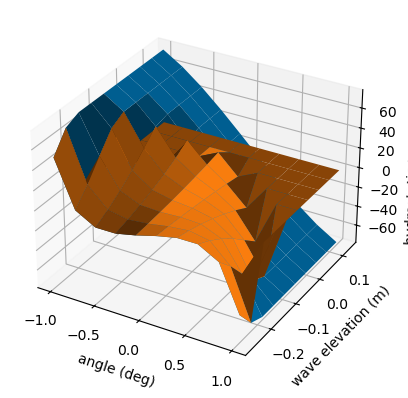

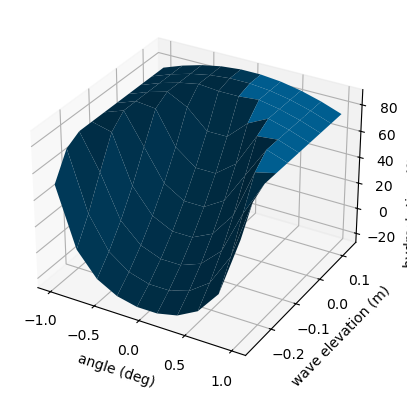

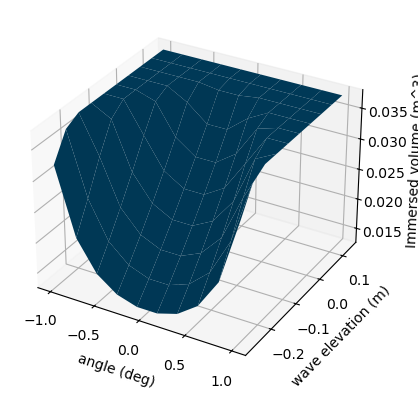

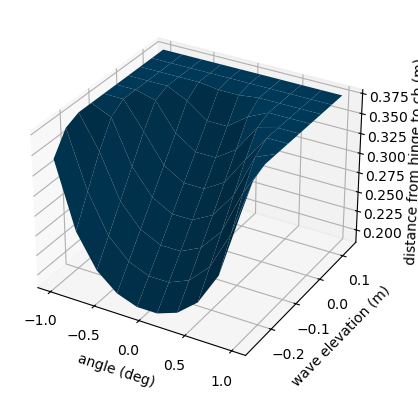

In [27]:
%matplotlib inline

# create grid of hydroatatic stiffness values
import logging
logging.getLogger().setLevel(logging.ERROR)

flap_fb = one_flap_FOSWEC(0.6, 0, 0.17, 0)
hs = flap_fb.compute_hydrostatics()
full_volume = hs['disp_volume']
#print(full_volume)

angle_vec = np.linspace(-1,1,10)
draft_vec = np.linspace(0.46+amplitude,0.46-amplitude,10)

hs_torque_vec = np.zeros((len(angle_vec),len(draft_vec)))
hs_stiffness_vec = np.zeros((len(angle_vec),len(draft_vec)))
capy_hs = np.zeros((len(angle_vec),len(draft_vec)))
vol_mat = np.zeros((len(angle_vec),len(draft_vec)))
hs_torque_partial = np.zeros((len(angle_vec),len(draft_vec)))
cb_dist_mat = np.zeros((len(angle_vec),len(draft_vec)))

xc = 0
mass = 23.1
rho = 1000
g = 9.81

for angleInd, angle in enumerate(angle_vec):
    for draftInd, draft in enumerate(draft_vec):
        flap_fb = one_flap_FOSWEC(draft, 0, 0.17, angle)

        hinge_location = [0, 0, -draft - 0.046]
        
        hs = flap_fb.compute_hydrostatics()

        V = hs['disp_volume']
        vol_mat[angleInd][draftInd] = V
        capy_hs[angleInd][draftInd] = hs['hydrostatic_stiffness']
        cb_z = np.sqrt((hs['center_of_buoyancy'][0] - hinge_location[0])**2 + (hs['center_of_buoyancy'][1] - hinge_location[1])**2 + (hs['center_of_buoyancy'][2] - hinge_location[2])**2) # distance from hinge to center of buoyancy
        cb_dist_mat[angleInd][draftInd] = cb_z
        cg_z = 0.17 + 0.046 # including distance from hinge to bottom
        #mass = 23.1
        rho = 1000
        g = 9.81
        hs_torque = -rho*V*g*cb_z*np.sin(angle) + mass*g*cg_z*np.sin(angle)
        hs_torque_vec[angleInd][draftInd] = hs_torque
        hs_stiffness_vec[angleInd][draftInd] = -hs_torque/angle

        #print(V)
        if not np.isclose(V,full_volume,atol=1e-5):
            hs_torque_partial[angleInd][draftInd] = hs_torque

        #flap_fb = flap_fb.keep_immersed_part()
        #hs = flap_fb.compute_hydrostatics()
        #pitch_stiffness_mat[angleInd, draftInd] = hs['hydrostatic_stiffness']
        #hs_torque = -rho*V*g*cb_z*np.sin(angle) + mass*g*cg_z*np.sin(angle)
        #hs_torque_vec.append(hs_torque)
        #hs_stiffness_vec.append(-hs_torque/angle)
        #zc = -draft - 0.046
        #norm_hs_stiff = (-flap_fb.waterplane_integral((flap_fb.mesh.faces_centers[:,0] - xc)**2) + flap_fb.volume*(flap_fb.center_of_buoyancy[2] - zc) - mass/rho*(flap_fb.center_of_mass[2] - zc))
        #hs_stiff = rho*g*norm_hs_stiff
        #hs_capy_mass_mat[angleInd, draftInd] = hs_stiff

X, Y = np.meshgrid(angle_vec,draft_vec-0.53)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X,Y,np.transpose(hs_torque_vec))
ax.plot_surface(X,Y,np.transpose(hs_torque_partial))
ax.set_xlabel('angle (deg)')
ax.set_ylabel('wave elevation (m)')
ax.set_zlabel('hydrostatic torque (Nm)')

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X,Y,np.transpose(hs_stiffness_vec))
ax.set_xlabel('angle (deg)')
ax.set_ylabel('wave elevation (m)')
ax.set_zlabel('hydrostatic stiffness (Nmrad/s)')

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X,Y,np.transpose(vol_mat))
ax.set_xlabel('angle (deg)')
ax.set_ylabel('wave elevation (m)')
ax.set_zlabel('Immersed volume (m^3)')

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X,Y,np.transpose(cb_dist_mat))
ax.set_xlabel('angle (deg)')
ax.set_ylabel('wave elevation (m)')
ax.set_zlabel('distance from hinge to cb (m)')

[ 0.77777778  1.          0.11111111  0.33333333  0.55555556  0.77777778
  1.         -0.11111111  0.11111111  0.33333333  0.55555556  0.77777778
  1.         -0.33333333 -0.11111111  0.11111111  0.33333333  0.55555556
  0.77777778  1.         -0.55555556 -0.33333333 -0.11111111  0.11111111
  0.33333333  0.55555556  0.77777778  1.         -0.55555556 -0.33333333
 -0.11111111  0.11111111  0.33333333  0.55555556  0.77777778  1.
 -0.33333333 -0.11111111  0.11111111  0.33333333  0.55555556  0.77777778
  1.         -0.11111111  0.11111111  0.33333333  0.55555556  0.77777778
  1.          0.11111111  0.33333333  0.55555556  0.77777778  1.
  0.77777778  1.        ]
[ 0.13        0.13        0.08555556  0.08555556  0.08555556  0.08555556
  0.08555556  0.04111111  0.04111111  0.04111111  0.04111111  0.04111111
  0.04111111 -0.00333333 -0.00333333 -0.00333333 -0.00333333 -0.00333333
 -0.00333333 -0.00333333 -0.04777778 -0.04777778 -0.04777778 -0.04777778
 -0.04777778 -0.04777778 -0.04777778 -0.0

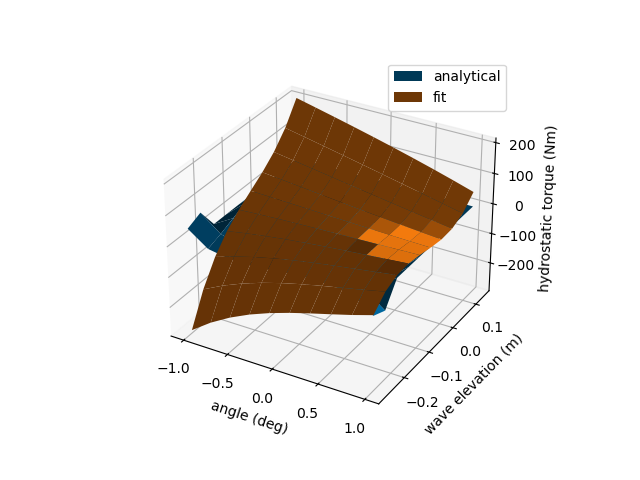

In [55]:
%matplotlib ipympl

angle_flat = X[hs_torque_partial != 0]
elev_flat = Y[hs_torque_partial != 0]
hs_torque_flat = hs_torque_partial[hs_torque_partial != 0]

print(angle_flat)
print(elev_flat)
print(hs_torque_flat)

# fit 3d function to torque vs. angle and elevation
# Define the 3D function to fit
def function_3d(data, a, b, c, d, e, f, g, h, i, j, k,l):
    x, y = data
    return a+x**3 + b*x**2 + c*x + d*y**3 + e*y**2 + f*y + g + h*x*y + i*x**2*y**2 + j*x**3*y**3 + k*x*y**2 + l*x*y**3

# Perform the curve fitting
popt, pcov = curve_fit(function_3d, (angle_flat, elev_flat), hs_torque_flat)

# Extract the optimized parameters
#a_opt, b_opt, c_opt, d_opt, e_opt, f_opt, g_opt, hopt, iopt, jopt, kopt = popt
print(popt)

# Create the fitted surface
z_fit = function_3d((X, Y), *popt)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X,Y,np.transpose(hs_torque_partial),label='analytical')
ax.plot_surface(X, Y, z_fit, label='fit')
ax.set_xlabel('angle (deg)')
ax.set_ylabel('wave elevation (m)')
ax.set_zlabel('hydrostatic torque (Nm)')
ax.legend()

[ 1.53222535e-04 -7.49496347e-05 -6.36582759e+00  3.81608845e+03
  8.01373405e+02  2.67442522e+02  1.61031812e+01 -1.69066527e+03
  1.00000000e+00  1.00000000e+00  1.00000000e+00  1.00000000e+00]


C:\Users\jtgrasb\AppData\Local\Temp\ipykernel_20756\1373959754.py:15: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(function_3d, (angle_flat, draft_flat), hs_torque_flat)


Text(0.5, 0, 'hydrostatic stiffness (Nmrad/s)')

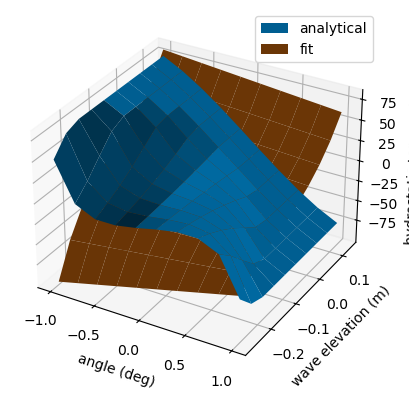

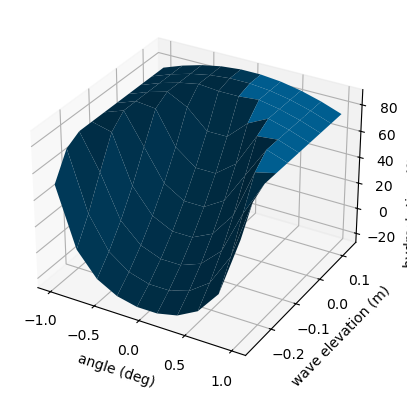

In [33]:
%matplotlib inline

# fit 3d function to torque vs. angle and elevation
# Define the 3D function to fit
def function_3d(data, a, b, c, d, e, f, g, h, i, j, k, l):
    x, y = data
    return a*x**3 + b*x**2 + c*x + d*y**3 + e*y**2 + f*y + g + h*x*y**3

# Generate some sample 3D data with noise
angle_flat = X.flatten()
draft_flat = Y.flatten()
hs_torque_flat = hs_torque_vec.flatten()

# Perform the curve fitting
popt, pcov = curve_fit(function_3d, (angle_flat, draft_flat), hs_torque_flat)

# Extract the optimized parameters
#a_opt, b_opt, c_opt, d_opt, e_opt, f_opt, g_opt, hopt, iopt, jopt, kopt = popt
print(popt)

# Create the fitted surface
z_fit = function_3d((X, Y), *popt)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X,Y,np.transpose(hs_torque_vec),label='analytical')
ax.plot_surface(X, Y, z_fit, label='fit')
ax.set_xlabel('angle (deg)')
ax.set_ylabel('wave elevation (m)')
ax.set_zlabel('hydrostatic torque (Nm)')
ax.legend()

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X,Y,np.transpose(hs_stiffness_vec))
ax.set_xlabel('angle (deg)')
ax.set_ylabel('wave elevation (m)')
ax.set_zlabel('hydrostatic stiffness (Nmrad/s)')

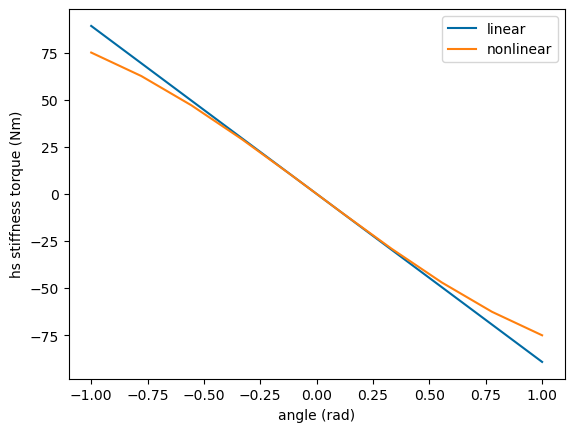

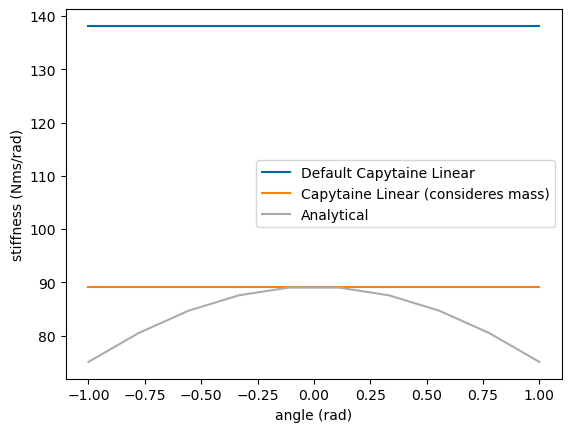

In [71]:
%matplotlib inline

# Calculate hydrostatic stiffness analytically for different angles (all fully submerged)
flap_fb = one_flap_FOSWEC(0.6, 0, 0.17, 0)

hs = flap_fb.compute_hydrostatics()
hs_capy = hs['hydrostatic_stiffness']
V = hs['disp_volume']
cb_z = hs['center_of_buoyancy'][2] - (-0.6 - 0.046) # distance from hinge to center of buoyancy
cg_z = 0.17 + 0.046 # including distance from hinge to bottom
mass = 23.1
rho = 1000
g = 9.81
hs_torque_vec = []
hs_stiffness_vec = []
lin_hs_torque_vec = []
lin_hs_mass_vec = []
lin_hs_mass = []

for angle in angle_vec:
    hs_torque = -rho*V*g*cb_z*np.sin(angle) + mass*g*cg_z*np.sin(angle)
    hs_torque_vec.append(hs_torque)
    hs_stiffness_vec.append(-hs_torque/angle)
    lin_hs_torque_vec.append(-hs_capy*angle)

    norm_hs_stiff = V*cb_z - mass/rho*cg_z
    hs_stiff = rho*g*norm_hs_stiff
    lin_hs_mass.append(hs_stiff)
    lin_hs_mass_vec.append(-hs_stiff*angle)

plt.figure()
plt.plot(angle_vec, np.squeeze(lin_hs_mass_vec),label='linear')
plt.plot(angle_vec, hs_torque_vec,label='nonlinear')
plt.xlabel('angle (rad)')
plt.ylabel('hs stiffness torque (Nm)')
plt.legend()

plt.figure()
plt.plot(angle_vec, hs_capy*np.ones((10,1)),label='Default Capytaine Linear')
#plt.plot(angle_vec, pitch_stiffness_mat[:,1],label='Default Capytaine Nonlinear')
plt.plot(angle_vec, lin_hs_mass, label='Capytaine Linear (consideres mass)')
#plt.plot(angle_vec, hs_capy_mass_mat[:,1],label='Capytaine Nonlinear (considers mass)')
plt.plot(angle_vec, hs_stiffness_vec,label='Analytical')
plt.xlabel('angle (rad)')
plt.ylabel('stiffness (Nms/rad)')
plt.legend()

In [72]:

#plt.figure()
#plt.plot(angle_vec, hs_stiffness_vec[:,0], label='nonlinear')
#plt.xlabel('angle (rad)')
#plt.ylabel('hydrostatic stiffness')

#hs_torque_lin = []
#hs_torque_nl = []

#for angle, pitch_stiffness in zip(angle_vec, hs_stiffness_vec[:,0]):
#    hs_torque_lin.append(coefficients[0]*angle)
#    hs_torque_nl.append(-pitch_stiffness*angle)

#plt.figure()
#plt.plot(angle_vec, np.squeeze(hs_torque_lin), label='linear')
#plt.plot(angle_vec, np.squeeze(hs_torque_nl), label='nonlinear')
#plt.xlabel('angle (rad)')
#plt.ylabel('torque (Nm)')

# fit function to curve
#coeffs_nl = np.polyfit(angle_vec, np.squeeze(hs_torque_nl),3)
#nl_fit = np.polyval(coeffs_nl, angle_vec)
#plt.plot(angle_vec, nl_fit, label='nl fit')
#plt.legend()



Text(0.07047665878555723, 0.5, 'torque (Nm)')

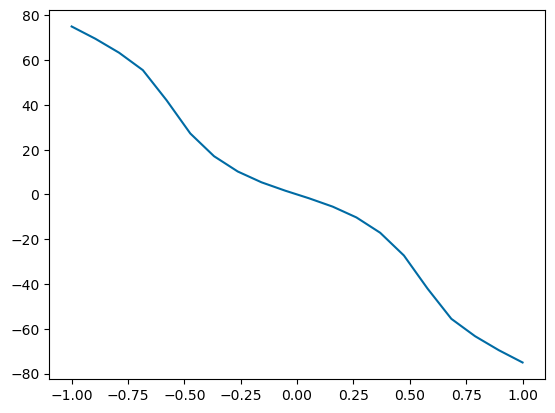

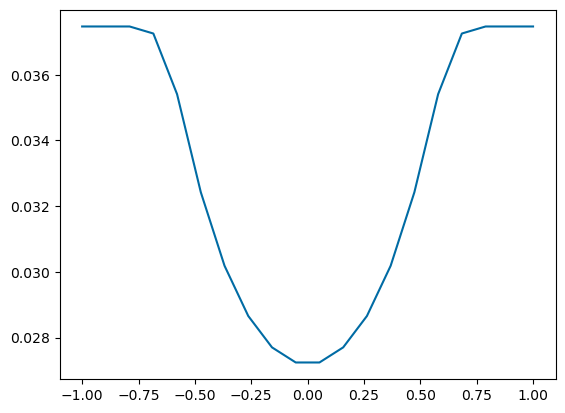

In [73]:
#  challenge is to select where piecewise starts and ends (based on displaced volume)
angle_vec = np.linspace(-1,1,20)

draft = 0.46
hs_torque_vec = []
hs_stiffness_vec = []
displaced_volume = []
capy_hs = []

for angleInd, angle in enumerate(angle_vec):
    flap_fb = one_flap_FOSWEC(draft, 0, 0.17, angle)

    hinge_location = [0, 0, -draft - 0.046]
    
    hs = flap_fb.compute_hydrostatics()

    V = hs['disp_volume']
    displaced_volume.append(V)
    capy_hs.append(hs['hydrostatic_stiffness'])
    cb_z = np.sqrt((hs['center_of_buoyancy'][0] - hinge_location[0])**2 + (hs['center_of_buoyancy'][1] - hinge_location[1])**2 + (hs['center_of_buoyancy'][2] - hinge_location[2])**2) # distance from hinge to center of buoyancy
    cg_z = 0.17 + 0.046 # including distance from hinge to bottom
    #mass = 23.1
    rho = 1000
    g = 9.81
    hs_torque = -rho*V*g*cb_z*np.sin(angle) + mass*g*cg_z*np.sin(angle)
    hs_torque_vec.append(hs_torque)
    hs_stiffness_vec.append(-hs_torque/angle)

plt.figure()
plt.plot(angle_vec,hs_torque_vec)
ax.set_xlabel('angle (deg)')
ax.set_ylabel('torque (Nm)')

plt.figure()
plt.plot(angle_vec,displaced_volume)
ax.set_xlabel('angle (deg)')
ax.set_ylabel('torque (Nm)')


In [ ]:
# analytically determine the torque for surface-piercing flap
#  challenge is to select where piecewise starts and ends (based on displaced volume)
angle_vec = np.linspace(-1,1,20)

draft = 0.46
hs_torque_vec = []
hs_stiffness_vec = []
displaced_volume = []
capy_hs = []

flap_width = 0.76
flap_thickness_bottom = 0.05
flap_thickness_top = 0.12
flap_height = 0.58 

original_volume = draft*flap_thickness_top*(draft/flap_height) - 0.5*(flap_thickness_top - flap_thickness_bottom)*draft
hinge_to_waterline_at_center = 

for angleInd, angle in enumerate(angle_vec):
    flap_fb = one_flap_FOSWEC(draft, 0, 0.17, angle)

    hinge_location = [0, 0, -draft - 0.046]

    displaced_volume = 
    
    hs = flap_fb.compute_hydrostatics()

    V = hs['disp_volume']
    displaced_volume.append(V)
    capy_hs.append(hs['hydrostatic_stiffness'])
    cb_z = np.sqrt((hs['center_of_buoyancy'][0] - hinge_location[0])**2 + (hs['center_of_buoyancy'][1] - hinge_location[1])**2 + (hs['center_of_buoyancy'][2] - hinge_location[2])**2) # distance from hinge to center of buoyancy
    cg_z = 0.17 + 0.046 # including distance from hinge to bottom
    #mass = 23.1
    rho = 1000
    g = 9.81
    hs_torque = -rho*V*g*cb_z*np.sin(angle) + mass*g*cg_z*np.sin(angle)
    hs_torque_vec.append(hs_torque)
    hs_stiffness_vec.append(-hs_torque/angle)

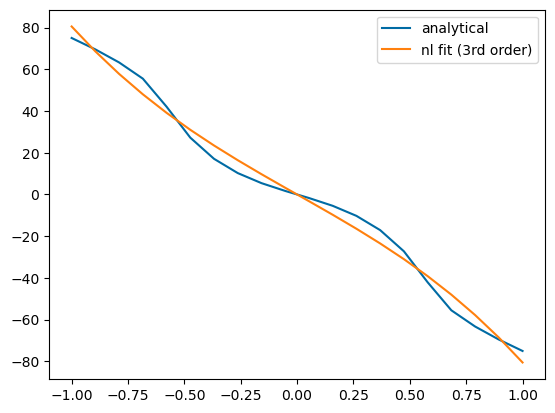

In [74]:
plt.figure()
plt.plot(angle_vec,hs_torque_vec,label='analytical')
ax.set_xlabel('angle (deg)')
ax.set_ylabel('torque (Nm)')

# fit function to curve
coeffs_nl3 = np.polyfit(angle_vec, np.squeeze(hs_torque_vec),3)
coeffs_nl3 = coeffs_nl3.tolist()
coeffs_nl5 = np.polyfit(angle_vec, np.squeeze(hs_torque_vec),5)
coeffs_nl5 = coeffs_nl5.tolist()
nl_fit = np.polyval(coeffs_nl3, angle_vec)
plt.plot(angle_vec, nl_fit, label='nl fit (3rd order)')
plt.legend()

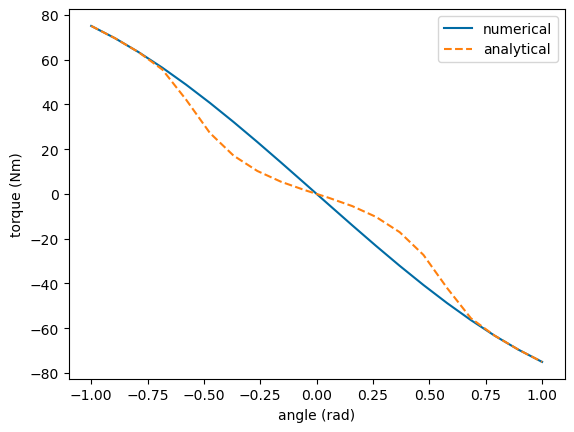

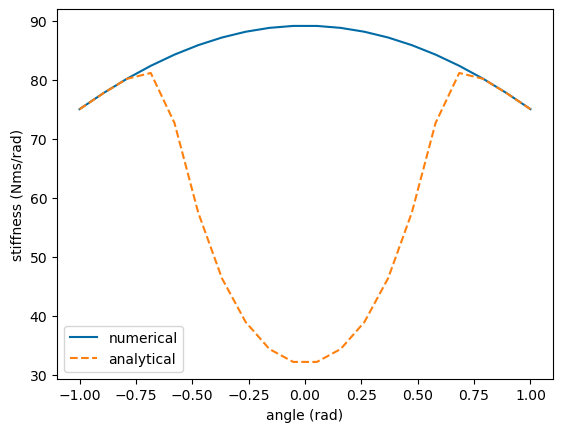

In [75]:
# compute stiffness numerically

stiffness_torque_ws = []
pitch_stiffness_check_ws = []

for angle in angle_vec:
    flap_fb = one_flap_FOSWEC(0.6, 0, 0.17, angle)

    # compute hydrostatic stiffness numerically
    av = flap_fb.mesh.faces_normals*np.transpose((flap_fb.mesh.faces_areas, flap_fb.mesh.faces_areas, flap_fb.mesh.faces_areas)) # av is normals*areas
    z = flap_fb.mesh.faces_centers[:,2]
    pressureVect = 1000*9.81*np.transpose((-z, -z, -z))*-av
    axis_pitch = (0, 0, -0.6-.046)
    #axis_pitch = (0, 0, -0.29)
    # Compute force about cog
    f = np.zeros((6))
    f[0:3] = sum(pressureVect)
    tmp1 = np.ones((len(flap_fb.mesh.faces_centers[:,0]),1))
    tmp2 = tmp1*np.transpose(axis_pitch) # does it make sense that this would be 3x1?
    center2cgVec = flap_fb.mesh.faces_centers-tmp2
    f[3:]= sum(np.cross(center2cgVec,pressureVect))

    torque_gravity = mass*g*cg_z*np.sin(angle)
    pitch_force_check = f[4] + torque_gravity
    stiffness_torque_ws.append(pitch_force_check)
    pitch_stiffness_check_ws.append(-pitch_force_check/angle)


plt.figure()
plt.plot(angle_vec, stiffness_torque_ws, label='numerical')
plt.plot(angle_vec, hs_torque_vec, '--',label='analytical')
plt.xlabel('angle (rad)')
plt.ylabel('torque (Nm)')
plt.legend()

plt.figure()
plt.plot(angle_vec, pitch_stiffness_check_ws, label='numerical')
plt.plot(angle_vec, hs_stiffness_vec, '--',label='analytical')
plt.xlabel('angle (rad)')
plt.ylabel('stiffness (Nms/rad)')
plt.legend()

In [82]:

# add hydrostatic restoring force manually
k_hs = -coefficients[0]

#k_hs_nl = pitch_stiffness_vec

def f_hs_lin(wec, x_wec, x_opt, waves, nsubsteps=1):
    pos_fd = wec.vec_to_dofmat(x_wec)
    time_matrix = wec.time_mat_nsubsteps(nsubsteps)
    pos_td = np.dot(time_matrix, pos_fd)
    hydrostatic_restoring_force = -k_hs*pos_td
    return hydrostatic_restoring_force

def f_hs_nl(wec, x_wec, x_opt, waves, nsubsteps=1):
    pos_fd = wec.vec_to_dofmat(x_wec)
    time_matrix = wec.time_mat_nsubsteps(nsubsteps)
    pos_td = np.dot(time_matrix, pos_fd)
    nl_hs_force_at_pos = float(coeffs_nl[0])*pos_td**3 + float(coeffs_nl[1])*pos_td**2 + float(coeffs_nl[2])*pos_td + float(coeffs_nl[3])
    return nl_hs_force_at_pos

# instead of using the coefficients, let's try applying it analytically
def f_hs_nl(wec, x_wec, x_opt, waves, nsubsteps=1):
    pos_fd = wec.vec_to_dofmat(x_wec)
    time_matrix = wec.time_mat_nsubsteps(nsubsteps)
    pos_td = np.dot(time_matrix, pos_fd)
    nl_hs_force_at_pos = -rho*V*g*cb_z*np.sin(pos_td) + mass*g*cg_z*np.sin(pos_td)
    return nl_hs_force_at_pos

def f_hs_nl_surface_piercing_5th_order(wec, x_wec, x_opt, waves, nsubsteps=1):
    pos_fd = wec.vec_to_dofmat(x_wec)
    time_matrix = wec.time_mat_nsubsteps(nsubsteps)
    pos_td = np.dot(time_matrix, pos_fd)
    #nl_hs_force_at_pos = np.polyval(coeffs_nl5,pos_td)
    nl_hs_force_at_pos = coeffs_nl5[0]*pos_td**5 + coeffs_nl5[1]*pos_td**4 + coeffs_nl5[2]*pos_td**3 + coeffs_nl5[3]*pos_td**2 + coeffs_nl5[4]*pos_td + coeffs_nl5[5]
    return nl_hs_force_at_pos

def f_hs_nl_surface_piercing_3rd_order(wec, x_wec, x_opt, waves, nsubsteps=1):
    pos_fd = wec.vec_to_dofmat(x_wec)
    time_matrix = wec.time_mat_nsubsteps(nsubsteps)
    pos_td = np.dot(time_matrix, pos_fd)
    #nl_hs_force_at_pos = np.polyval(coeffs_nl3,pos_td)
    nl_hs_force_at_pos = coeffs_nl3[0]*pos_td**3 + coeffs_nl3[1]*pos_td**2 + coeffs_nl3[2]*pos_td + coeffs_nl3[3]
    return nl_hs_force_at_pos

In [83]:
omega = bem_data.omega.values
gear_ratio = 3.75
torque_constant = 6.7
winding_resistance = 0.5
winding_inductance = 0
drivetrain_inertia = 0
drivetrain_friction = 0
drivetrain_stiffness = 0

drivetrain_impedance = (1j*omega*drivetrain_inertia + 
                        drivetrain_friction + 
                        1/(1j*omega)*drivetrain_stiffness) 

winding_impedance = winding_resistance + 1j*omega*winding_inductance


pto_impedance_11 = -1* gear_ratio**2 * drivetrain_impedance
off_diag = np.sqrt(3.0/2.0) * torque_constant * gear_ratio
pto_impedance_12 = -1*(off_diag+0j) * np.ones(omega.shape) 
pto_impedance_21 = -1*(off_diag+0j) * np.ones(omega.shape)
pto_impedance_22 = winding_impedance
pto_impedance = np.array([[pto_impedance_11, pto_impedance_12],
                        [pto_impedance_21, pto_impedance_22]])

## Update PTO
name = ['PTO_Pitch']
kinematics = np.eye(1)
pto_ndof = 1
controller = None # unstructured controller
loss = None
pto = wot.pto.PTO(pto_ndof, kinematics, controller, pto_impedance, loss, name)

# PTO dynamics forcing function
f_add = {'PTO': pto.force_on_wec,'hydrostatic_restoring': f_hs_nl_surface_piercing_5th_order}

# Constraint
pos_max = 30*np.pi/180
rms_max = 20
nsubsteps = 4

def const_pos_pto(wec, x_wec, x_opt, waves):
    pos = pto.position(wec, x_wec, x_opt, waves, nsubsteps) # computed pto position is the same as wec position
    return pos_max - np.abs(pos.flatten())

def const_rms_power_pto(wec, x_wec, x_opt, waves):
    power = pto.power(wec, x_wec, x_opt, waves, nsubsteps)
    return rms_max - np.sqrt(np.mean(power**2))

constraints = [{'type': 'ineq', 'fun': const_pos_pto}, {'type': 'ineq', 'fun': const_rms_power_pto}] 

wec = wot.WEC.from_bem(bem_data,
                        constraints=constraints,
                        friction=12*np.eye(1), # tuned variable
                        f_add=f_add,)

In [87]:
import logging
logging.getLogger().setLevel(logging.INFO)

# Update objective function
nstate_opt = 2*nfreq

# Solve
scale_x_wec = 1e1
scale_x_opt = 1e-1
scale_obj = 1e1

options = {'maxiter': 400}

nsubsteps = 4

obj_fun = pto.average_power

waves_init = wot.complex_to_real(np.hstack((0,np.squeeze(waves))),zero_freq=True)
init_vec = np.squeeze(waves_init)
    
results = wec.solve(
    waves, 
    obj_fun, 
    nstate_opt, 
    optim_options=options, 
    scale_x_wec=scale_x_wec,
    scale_x_opt=scale_x_opt,
    scale_obj=scale_obj,
    x_wec_0 = init_vec,
)


c:\Users\jtgrasb\AppData\Local\anaconda3\envs\wot_dev\Lib\site-packages\wecopttool\core.py:756: UserWarning: The `squeeze` kwarg to GroupBy is being removed.Pass .groupby(..., squeeze=False) to disable squeezing, which is the new default, and to silence this warning.
  for realization, wave in waves.groupby('realization'):
INFO:wecopttool.core:Solving pseudo-spectral control problem for realization number 0.
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.62e+00, 7.41e-01, 3.86e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.94e+00, 6.33e-01, -2.03e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.48e+00, 7.11e-01, -3.05e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.07e+00, 8.73e-01, -2.89e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.46e+00, 9.74e-01, -2.82e+00]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.36e+00, 1.01e+00, -3.69e+00]
I

Optimization terminated successfully    (Exit mode 0)
            Current function value: -4.355866940691202
            Iterations: 24
            Function evaluations: 39
            Gradient evaluations: 24


### Results


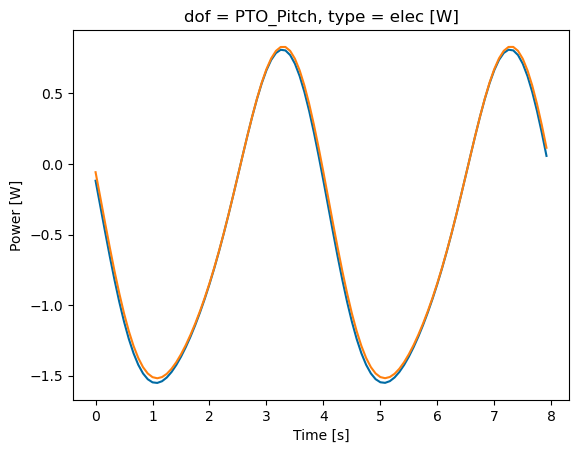

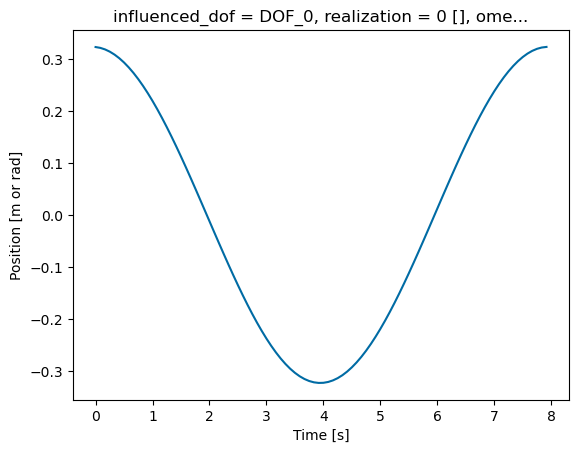

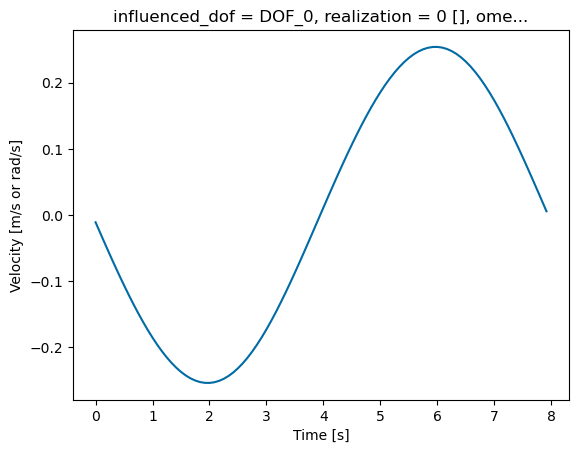

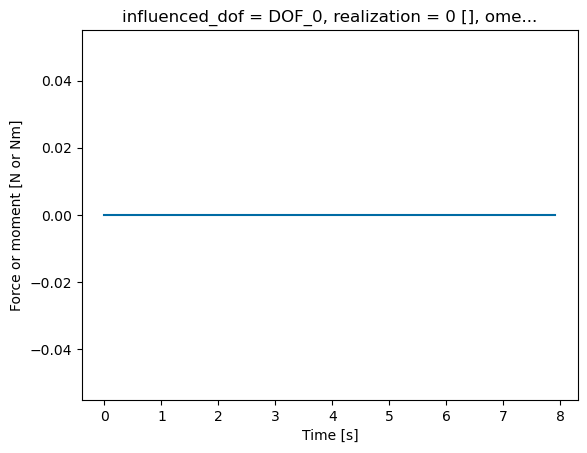

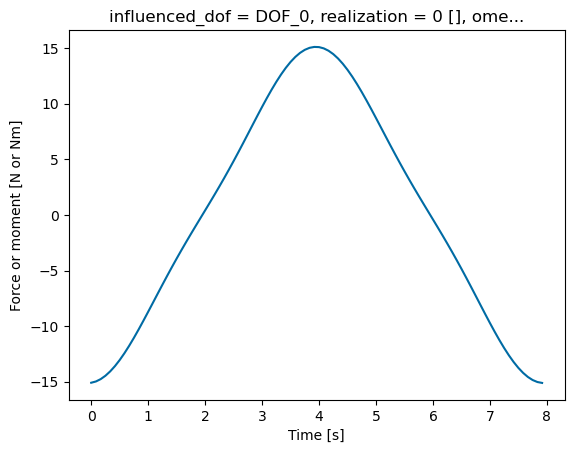

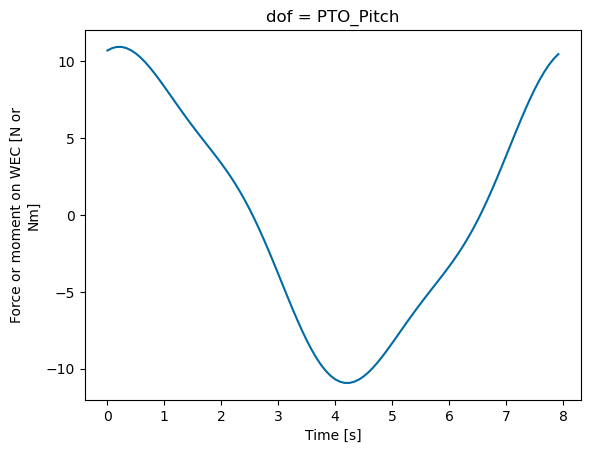

In [85]:
pto_fdom, pto_tdom = pto.post_process(wec, results, waves, nsubsteps=nsubsteps)
wec_fdom, wec_tdom = wec.post_process(wec, results, waves, nsubsteps=nsubsteps)

plt.figure()
pto_tdom[0]['power'].loc['mech',:,:].plot()
pto_tdom[0]['power'].loc['elec',:,:].plot()

plt.figure()
wec_tdom[0]['pos'].plot()

plt.figure()
wec_tdom[0]['vel'].plot()

plt.figure()
wec_tdom[0]['force'].sel(type='hydrostatics').plot()

plt.figure()
wec_tdom[0]['force'].sel(type='hydrostatic_restoring').plot()

plt.figure()
pto_tdom[0]['force'].plot()